<font color="#CC3D3D"><p>
# Building a DNN Model with Keras

####  전역변수 설정

In [9]:
DNN_VERSION = 1.0  # Model version
SEED = 0           # random_state 지정

In [8]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
   pip install keras-tuner

  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
print(tf.__version__)

2.17.0


In [11]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(SEED)
    random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


#### (전처리된) 데이터 로딩

In [14]:
# 학습 데이터
X_train = pd.read_csv('/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/data/X_train.csv').drop(columns='ID')
y_train = pd.read_csv('/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/data/y_train.csv').Salary

# 평가 데이터
X_test = pd.read_csv('/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/data/X_test.csv')
test_id = X_test.ID
X_test = X_test.drop(columns='ID')

In [15]:
X_train

,f001,f002,f003,f004,f005,f006,f007,f008,f009,f010,...,f678,f679,f680,f681,f682,f683,f684,f685,f686,f687
0,-0.030378,-0.646419,1.507623,-1.896928,-0.642709,-0.524335,-2.192519,4.448684,0.065995,1.310752,...,0,0,0,0,0,0,0,1,0,0
1,0.261887,0.021290,-0.831830,-0.733281,0.006152,-0.315621,-0.829256,-0.206005,-0.447145,-2.128087,...,0,0,0,0,0,0,1,0,0,0
2,-1.078848,-0.646419,-0.930195,-0.662700,-0.642709,-0.524335,-2.192519,-0.315188,-0.427094,0.595404,...,0,0,0,0,0,0,0,1,0,0
3,-2.098447,-0.417490,-0.846133,0.315168,-0.420242,-0.381217,-0.679935,-0.510454,-0.456195,0.595404,...,0,0,0,0,0,0,0,1,0,0
4,-2.402089,-0.646419,-0.846133,-1.454795,-0.642709,-0.524335,-2.192519,-0.619515,-0.402222,-0.464443,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16565,0.356914,-0.646419,-0.762070,-0.688668,-0.642709,-0.524335,-0.848000,2.287319,-0.392606,-0.749506,...,0,0,0,0,0,0,0,1,0,0
16566,0.795411,-0.646419,1.507623,-0.001319,-0.642709,-0.524335,0.537649,-0.206005,-0.029140,1.310752,...,0,0,0,0,0,0,0,1,0,0
16567,0.261887,-0.646419,-0.846133,-0.733281,-0.642709,-0.524335,-0.829256,-0.206005,0.026992,0.595404,...,0,0,0,0,0,0,1,0,0,0
16568,-1.913065,-0.646419,0.919184,0.416007,-0.642709,-0.524335,-0.609389,1.761456,-0.368161,-1.283700,...,0,0,0,0,0,0,0,1,0,0


In [16]:
# 학습 데이터를 다시 학습과 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

<font color="blue"><p>
#### DNN 모형 생성

<font color="blue"><p>
- 1단계: 모형 정의하기 (입력층/은닉층/출력층 쌓기)

In [18]:
inputs = keras.Input(shape=(X_train.shape[1], ))          # 입력층
x = keras.layers.Dense(128, activation='relu')(inputs)  # 첫번째 은닉층
x = keras.layers.Dense(64, activation='relu')(x)        # 두번째 은닉층
output = keras.layers.Dense(1, activation='linear')(x)  # 출력층

model = keras.Model(inputs=inputs, outputs=output)      # 입력층과 출력층을 지정함으로써 전체모형 정의

In [21]:
# 모형 구조 출력: Total params가 많을수록 복잡한 모델임.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 687)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        88,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,385 (376.50 KB)

 Trainable params: 96,385 (376.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 연결 그래프 시각화: graphviz와 pydot 설치 필요 (graphviz 다운로드하고 설치한 후 pip -U install pydot)
# conda install graphviz (MacOS)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<font color="blue"><p>
- 2단계: 학습방식(손실함수/옵티마이저/평가척도) 설정하기

In [26]:
model.compile(
    loss='mse',
#    optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.RMSprop(), # macOS                     
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

<font color="blue"><p>
- 3단계: 모형 학습하기 (에포크, 배치사이즈, 조기중단 등 지정) 

In [27]:
hist = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid,y_valid), # DNN 학습시 검증데이터가 필요함 => 미리 학습과 검증 데이터로 나누었을 경우
#    validation_split=0.1,             # DNN 학습시 검증데이터가 필요함 => 미리 나누지 않을 경우
    batch_size=64, 
    epochs=200, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)], # 검증데이터의 Loss가 5회연속 감소하지 않으면 학습 중단.
    shuffle=False,       # 재현을 위해 False로 설정.
    verbose=2,
)

Epoch 1/200
234/234 - 1s - 3ms/step - loss: 5280699.5000 - rmse: 2297.9773 - val_loss: 962851.6250 - val_rmse: 981.2501
Epoch 2/200
234/234 - 0s - 1ms/step - loss: 847890.1875 - rmse: 920.8095 - val_loss: 808724.7500 - val_rmse: 899.2913
Epoch 3/200
234/234 - 0s - 913us/step - loss: 766133.1250 - rmse: 875.2903 - val_loss: 781843.5625 - val_rmse: 884.2192
Epoch 4/200
234/234 - 0s - 807us/step - loss: 740163.4375 - rmse: 860.3275 - val_loss: 768733.9375 - val_rmse: 876.7747
Epoch 5/200
234/234 - 0s - 804us/step - loss: 725605.8750 - rmse: 851.8250 - val_loss: 760609.7500 - val_rmse: 872.1295
Epoch 6/200
234/234 - 0s - 784us/step - loss: 715644.8125 - rmse: 845.9579 - val_loss: 755193.2500 - val_rmse: 869.0186
Epoch 7/200
234/234 - 0s - 786us/step - loss: 708115.1250 - rmse: 841.4958 - val_loss: 751377.8750 - val_rmse: 866.8206
Epoch 8/200
234/234 - 0s - 789us/step - loss: 702068.5000 - rmse: 837.8953 - val_loss: 748607.8750 - val_rmse: 865.2213
Epoch 9/200
234/234 - 0s - 775us/step - lo

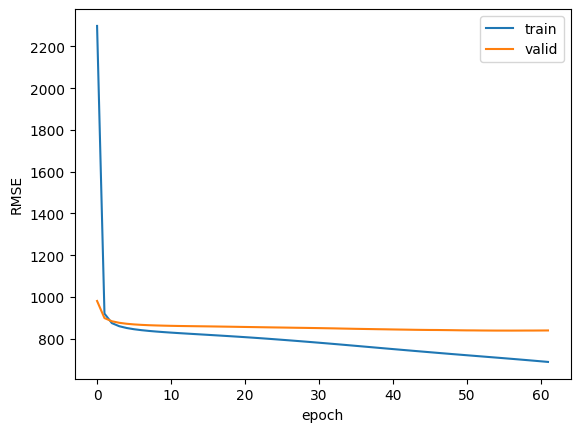

In [28]:
# 러닝커브 그리기: 학습이 잘되었는지 어느정도 판단할 수 있음.

plt.plot(hist.history['rmse'], label="train")
plt.plot(hist.history['val_rmse'], label="valid")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [29]:
results = model.evaluate(X_valid, y_valid)
print("valid loss, valid rmse:", results)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 702095.8125 - rmse: 836.9898
valid loss, valid rmse: [705790.625, 840.1134643554688]


<font color="blue"><p>
- 4단계: 예측하기

In [30]:
# 예측값 얻기: sklearn 과 달리 2차원 array로 출력 => 1차원으로 변경 필요.
pred = model.predict(X_test).flatten()

# submission 화일 생성
filename = f'dnn_{DNN_VERSION}_{hist.history["val_rmse"][-1]:.2f}.csv'
pd.DataFrame({'ID':test_id, 'Salary':pred}).to_csv(filename, index=False)

print(f'{filename} is ready to submit.')

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
dnn_1.0_840.11.csv is ready to submit.


<font color="#CC3D3D"><p>
# End